# Effect of prominent Macroeconomic factors on the Housing Price Index in the United States

## Table of Contents
1. Load Packages

2. Load Data

3. EDA

    3.1 Preliminary/High-Level EDA

    3.2 Some Further EDA

4. Model Fitting

    4.1 Model 1: All Predictors

    4.2 Model 2: Using Only Variables Chosen by RFE

    4.3 Model 3: Using Model 2 Less Insignificant Predictors
    
5. Model Selection

In [1]:
# choose whether run with docker or not, 1 corresponds to with docker, 0 without
docker_bool = 0

In [2]:
import matplotlib as mpl

# define new colour cycle
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# set the default colour cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle)

## 1. Load Packages

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import datetime

## 2. Load Data

### Variables
- Purchase only house price index: asdf
- Unemployment rate: asdf
- Consumer price index: asdf
- Inflation rate US: asdf
- Consumer sentiment: asdf
- Producer price index construction machinery manufacturing: asdf
- Average mortgage interest: asdf
- Personal income: asdf
- Moody's seasoned AAA corporate bond yield: asdf
- Home supply: asdf

In [4]:
# define series_id
series_id_dict = {"house_pi": 'CSUSHPISA',
                 "unemp_rate": "UNRATE",
                 "CPI": "USACPIALLMINMEI",
                 "cons_sent": "UMCSENT",
                 "PI_const": "PCU333120333120",
                 "mortgage_int": "MORTGAGE30US",
                 "personal_inc": "PI",
                 "corp_yield": "AAA",
                 "home_supply": "MSACSR",
                 "population": 'POPTHM',
                 "new_houses": 'HOUST',
                 "working_population": 'LFWA64TTUSM647S',
                 "NASDAQ": 'NASDAQCOM',
                 "VIX": 'VIXCLS'}

# get data folder path
project_name = "housing-price-index-us"
if docker_bool == 1:
    raw_data_path_docker = os.path.join('tmp', 'data', 'raw')

if docker_bool == 0:
    # get data folder path
    raw_data_path = os.path.join(os.environ["RESEARCH_PATH"], project_name, "data", "raw")

# get filename
observation_start = "2000-01-01"
observation_end = "2022-06-30"

filename_list = []
for id in series_id_dict:
    filename_list.append(f"data_{series_id_dict[id]}_{observation_start}_to_{observation_end}.feather")

In [5]:
# get first column (date) to start the df
if docker_bool == 1:
    data = pd.read_feather(os.path.join(raw_data_path_docker, filename_list[0])).iloc[:,0:1]
if docker_bool == 0:
    data = pd.read_feather(os.path.join(raw_data_path, filename_list[0])).iloc[:,0:1]

data.head()

,date
0,2000-01-01
1,2000-02-01
2,2000-03-01
3,2000-04-01
4,2000-05-01


In [6]:
# join all data together in a single pd.DataFrame
temp = 0
if docker_bool == 1:
    for key, value in series_id_dict.items():
        data[key] = pd.read_feather(os.path.join(raw_data_path_docker, filename_list[temp])).iloc[:,1:]
        temp += 1

data.head()

if docker_bool == 0:
    for key, value in series_id_dict.items():
        data[key] = pd.read_feather(os.path.join(raw_data_path, filename_list[temp])).iloc[:,1:]
        temp += 1

    data.head()

In [7]:
# change data type to float for all columns (but date)
for key, value in series_id_dict.items():
    data[key] = pd.to_numeric(data[key])

data['date'] = pd.to_datetime(data['date'])

data.head()

,date,house_pi,unemp_rate,CPI,cons_sent,PI_const,mortgage_int,personal_inc,corp_yield,home_supply,population,new_houses,working_population,NASDAQ,VIX
0,2000-01-01,100.552,4.0,71.218520,112.0,172.3,8.21,8382.6,7.78,4.3,281083.0,1636.0,1.782826e+08,4013.494000,23.20
1,2000-02-01,101.339,4.1,71.640431,111.3,172.3,8.33,8443.7,7.68,4.3,281299.0,1737.0,1.783298e+08,4410.871000,23.60
2,2000-03-01,102.127,4.0,72.231106,107.1,172.4,8.24,8503.7,7.68,4.3,281531.0,1604.0,1.783925e+08,4802.988261,22.72
3,2000-04-01,102.923,3.8,72.273297,109.2,172.7,8.15,8542.9,7.64,4.4,281763.0,1626.0,1.785776e+08,3863.637368,27.16
4,2000-05-01,103.678,4.0,72.357679,110.7,172.6,8.52,8580.9,7.99,4.4,281996.0,1575.0,1.787291e+08,3528.416818,26.37


## 3. EDA

### 3.1 Preliminary/High-Level EDA

In [8]:
#print(data.head())
print('******************************************************************************************')
#print(data.shape)
print('******************************************************************************************')
#print(data.dtypes) # all floats except for 'date' which is datetime
print('******************************************************************************************')
#print(data.info())
print('******************************************************************************************')
print(data.isnull().sum()) # no null data

******************************************************************************************
******************************************************************************************
******************************************************************************************
******************************************************************************************
date                  0
house_pi              0
unemp_rate            0
CPI                   0
cons_sent             0
PI_const              0
mortgage_int          0
personal_inc          0
corp_yield            0
home_supply           0
population            0
new_houses            0
working_population    0
NASDAQ                0
VIX                   0
dtype: int64


### 3.2 Some Further EDA

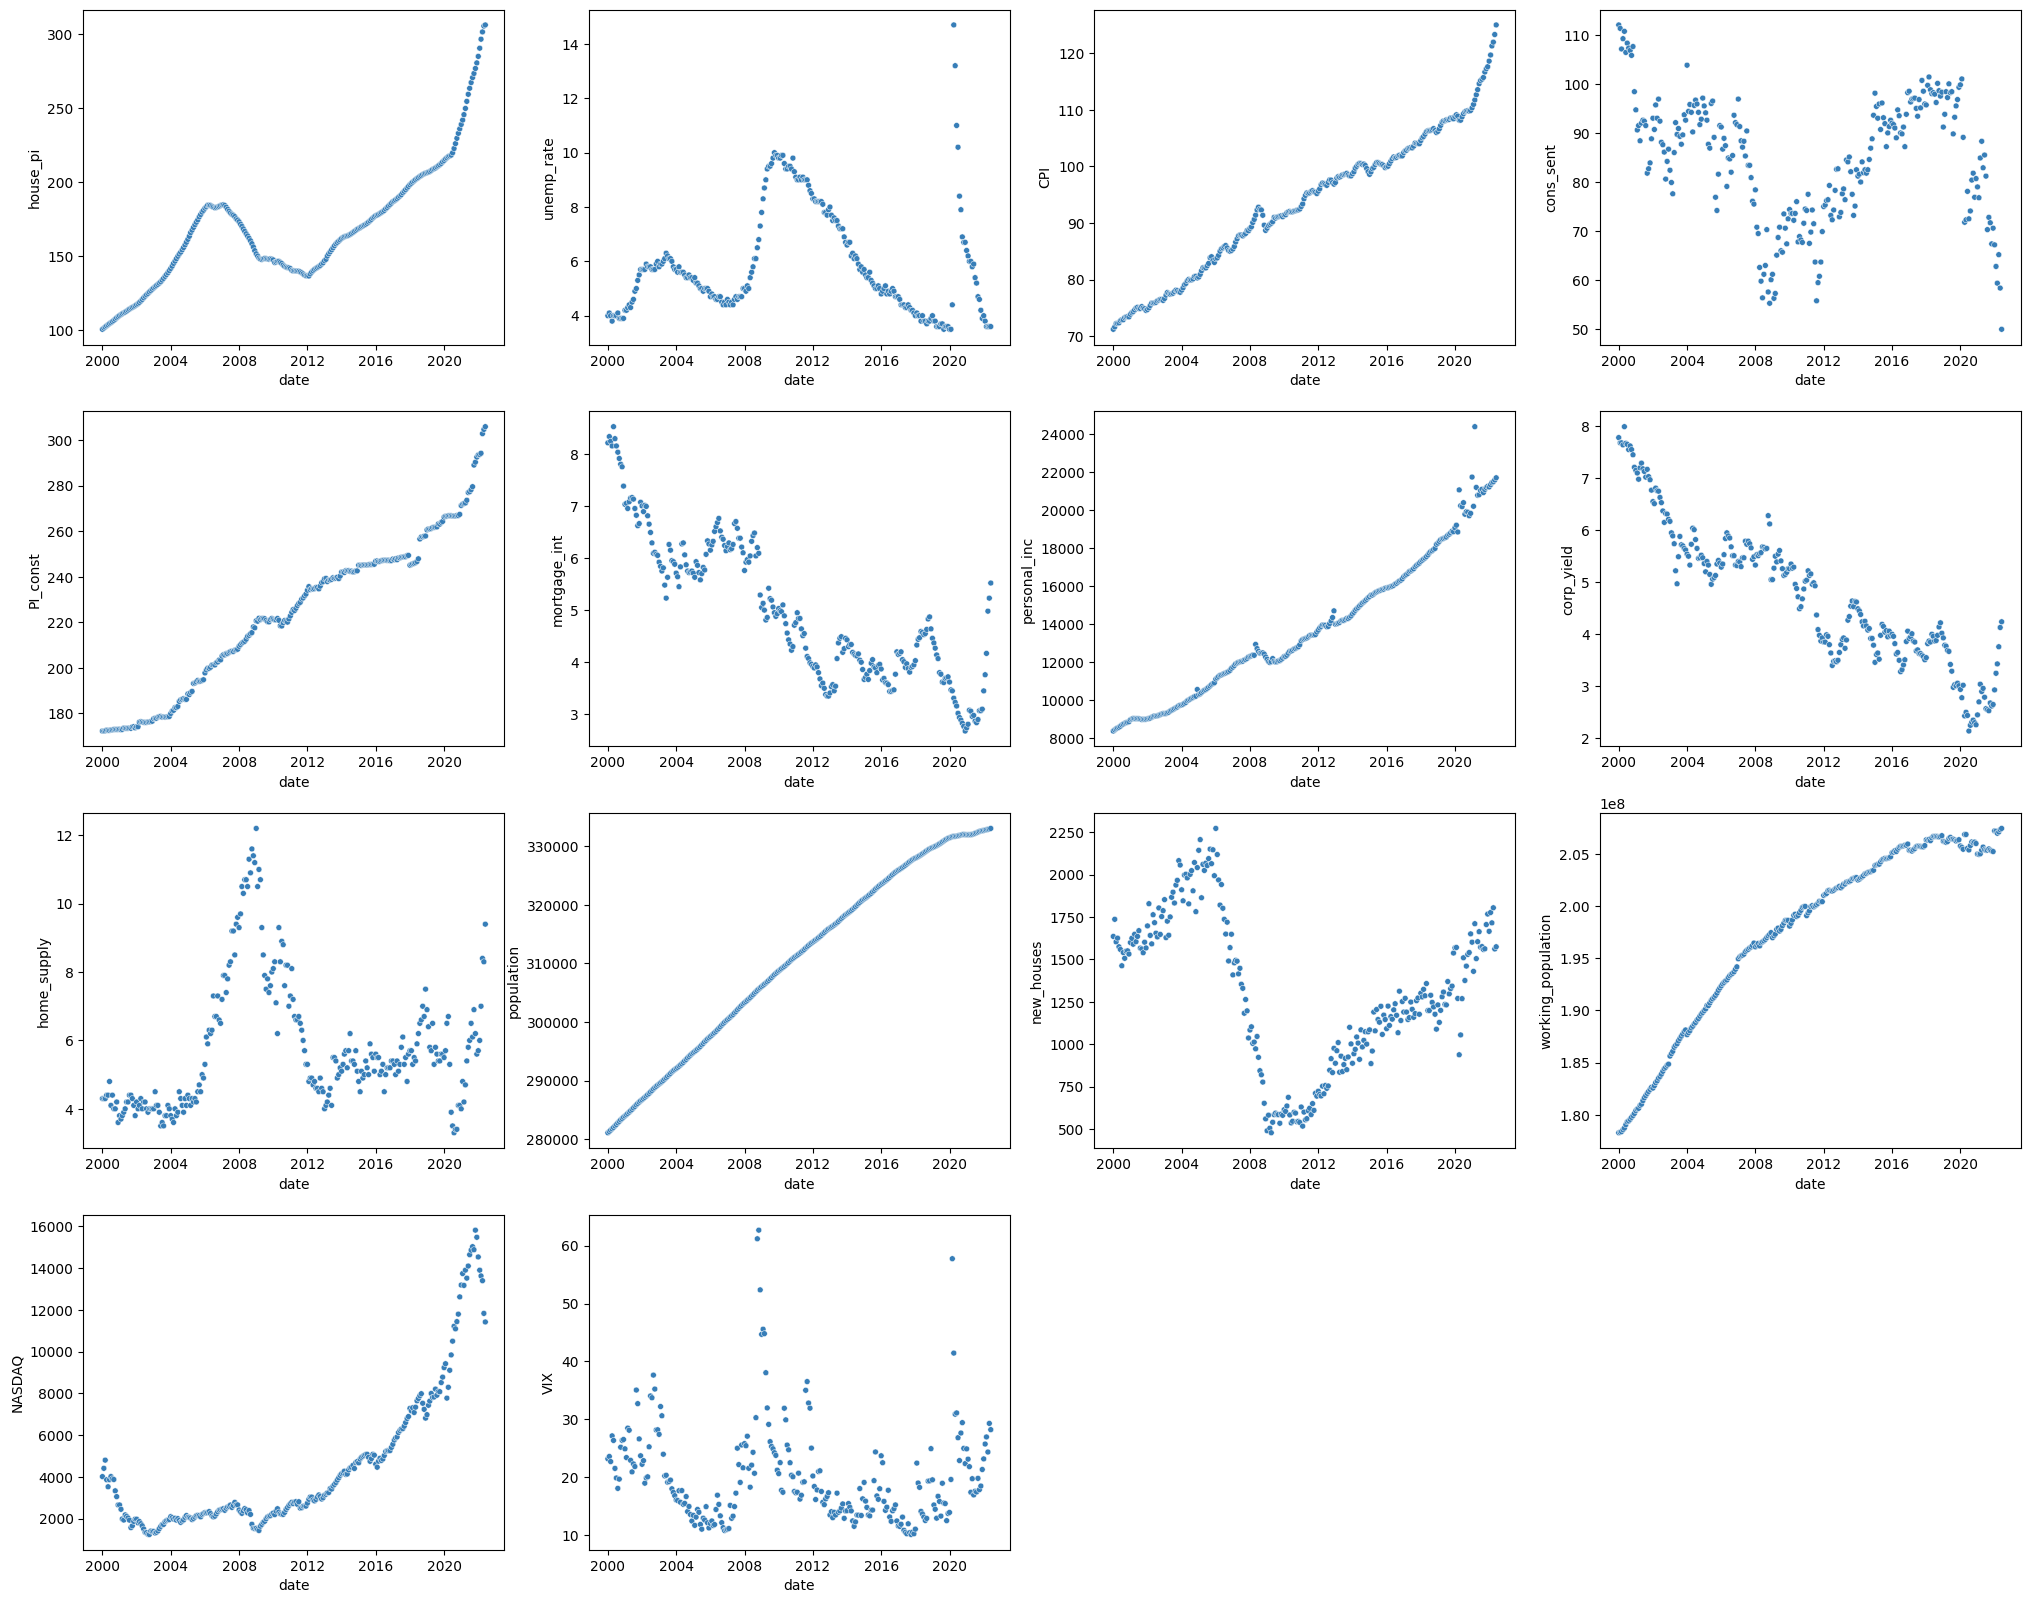

In [9]:
# plot how each variable evolves over time
cols = data.columns[1:,] # don't plot date against itself
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data, x = data['date'], y = i, size = 5, legend = False)
    k += 1


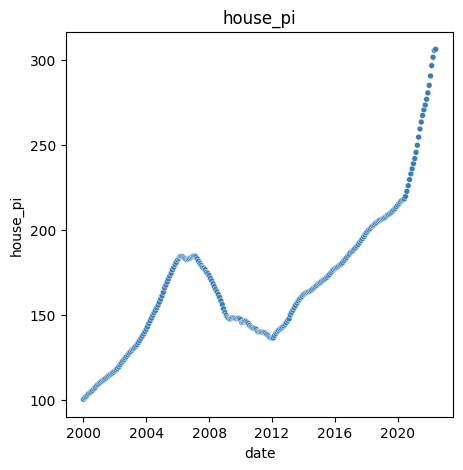

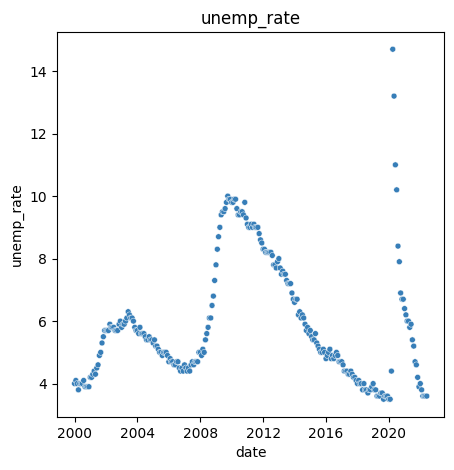

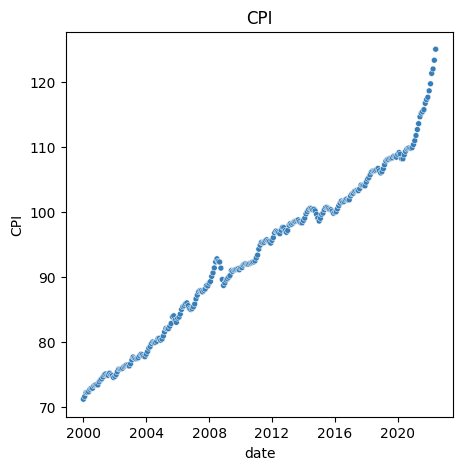

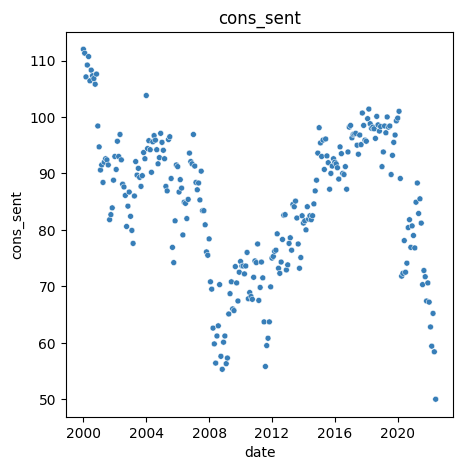

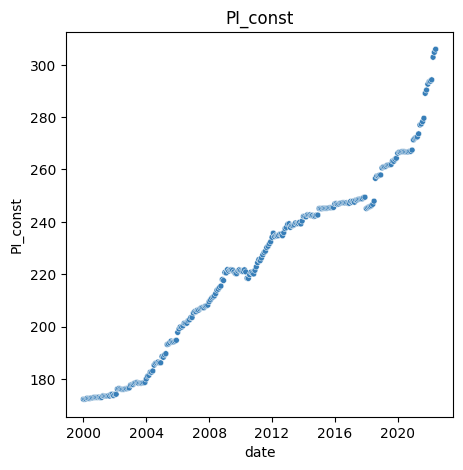

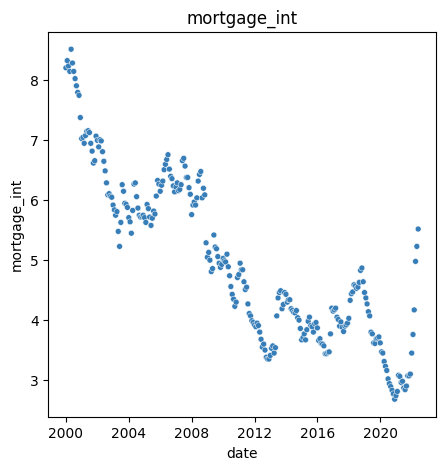

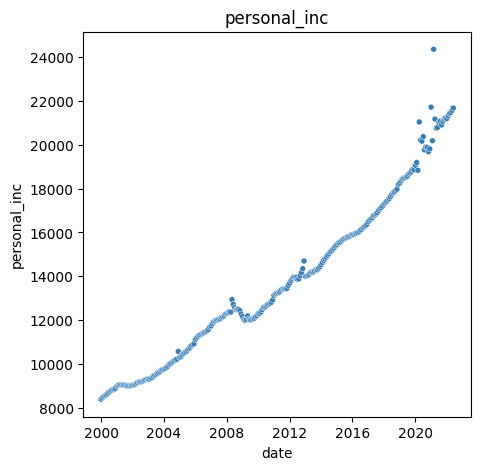

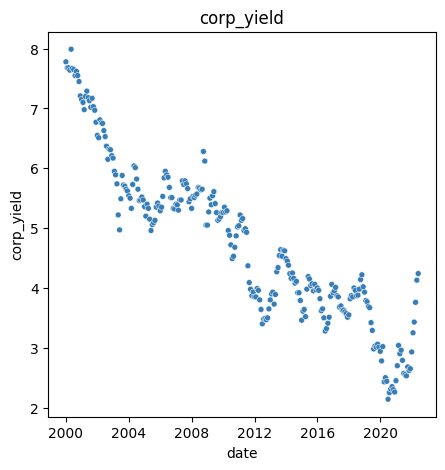

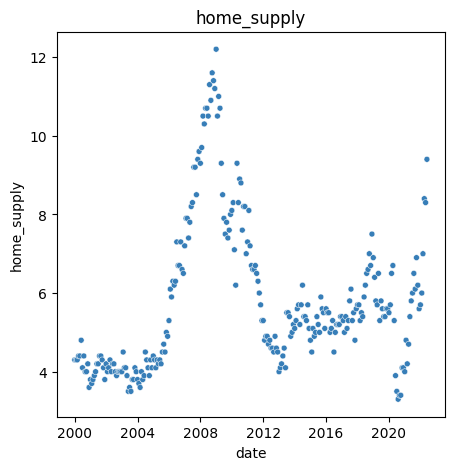

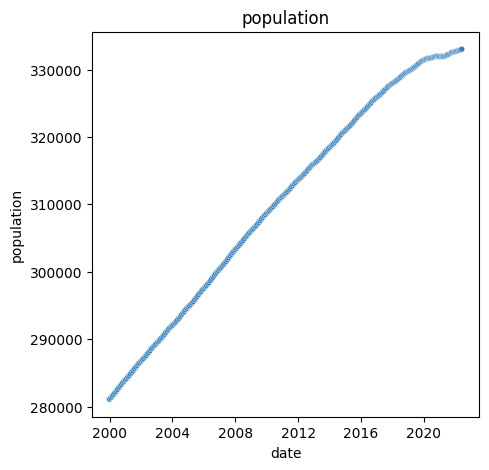

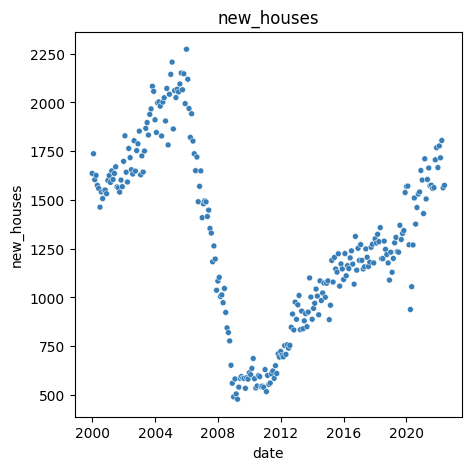

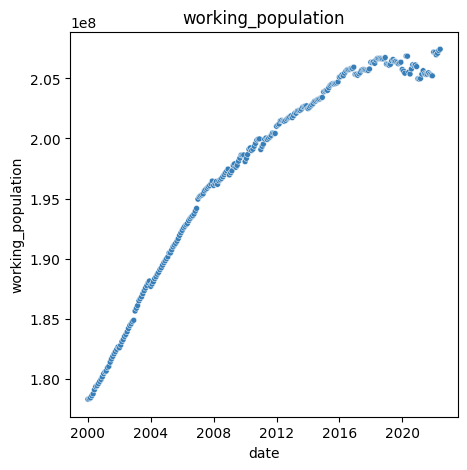

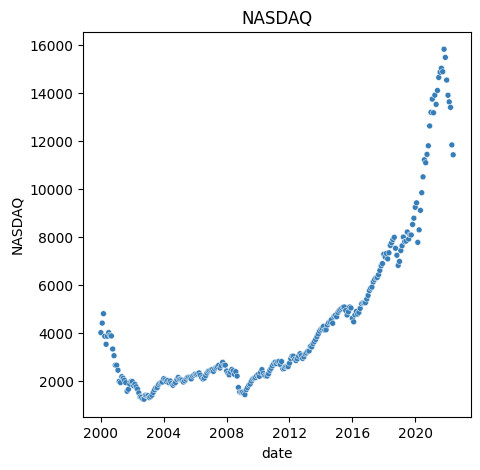

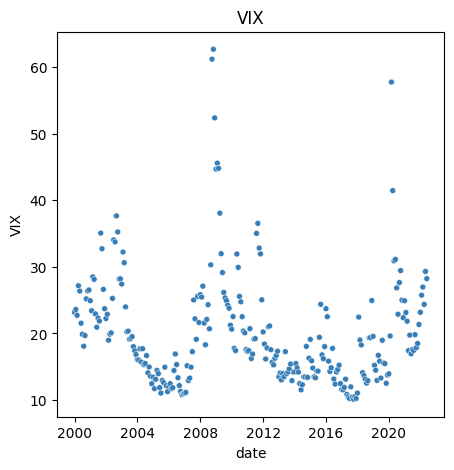

In [12]:
if docker_bool == 1:
    cols = data.columns[1:,]
    save_folder_docker = os.path.join('reports', 'figures', '')

    for i in cols:
        plt.figure(figsize = (5,5))
        sns.scatterplot(data = data, x = data['date'], y = i, size = 5, legend = False).set(title = i)
        plt.savefig(os.path.join(f'{save_folder_docker}{i}.png'))

if docker_bool == 0:
    cols = data.columns[1:,]
    save_folder = os.path.join(os.environ['RESEARCH_PATH'], 'housing-price-index-us', 'reports', 'figures', '')
    
    for i in cols:
        plt.figure(figsize = (5,5))
        sns.scatterplot(data = data, x = data['date'], y = i, size = 5, legend = False).set(title = i)
        plt.savefig(os.path.join(f'{save_folder}{i}.png'))


Interpretation:
- 'house_pi' has a clearly upwards-sloping trend with a serious uptick in the years leading up to the year 2007/08. This is not surprising as we know today that in the build-up of the subprime crisis real estate prices skyrocketed before the housing price bubble burst. After a short period of price corrections up until ca. the year 2012, the prices have again risen and still are.
- 'unemp_rate' has seen upticks after every major crisis - dotcom bubble in the early 21st century, the financial crisis starting in 2008 and very recently the Corona pandemic.
- 'CPI' has steadily risen since the the beginning of the 21st century. Since and because of the corona pandemic and additionally fuelled by the on-going war in eastern Europe, we have seen major yoy increases in inflation. Central banks around the world have tried to get inflation under control by increasing interest rates which has not shown much effect up to the end of our sample time.
- 'cons_sent' paints a somewhat cyclical picture, marked by the recessions caused by the big crises in the 21st century thus far, as mentioned above.
- 'PI_const' looks, unsurprisingly, very similar to the broader 'CSI'. As such, it is also in line with our expectations.
- Up until ca. 2020, 'mortagage_int' exhibits a clear downwards-sloping trend sparked yet again by the recent crises. Since 2020, however, we observe a turnaround which is in close connection to the effort of central banks (especially the FED) to curb inflation.
- 'personal_inc' has experienced a steady upwards-sloping trend since the start date of our data set which obviously follows from the increase in inflation over the past centuries. Note, however, that naturally due to the nature of salary negotiations, the line is much smoother compared to the one of 'CPI'.
- 'corp_yield' has a very similar evolution over time as 'mortgage_int' which is not particularly surprising since for both, the prime rate has a very big impact.
- The 'home_supply' has a slight upwards-sloping trend with a huge upwards move shortly before the subprime crisis. Notice, that while 'house_pi' started increasing rapidly after its low point, 'home_supply' had more of a slow trod before its volatilty started increasing from the year 2020 onwards.
- 'population' is strictly monotonically increasing which makes sense.
- 'new_houses' had mainly increasing values except for the subprime crisis. After that, the number of new houses for sale have again steadily increased at seemingly the same rate as before the crisis.
- 'working_population' behaves very much like 'population' as expected. One difference is, however, that 'population' is smoother which also makes sense since growth in the population is naturally much more steady.

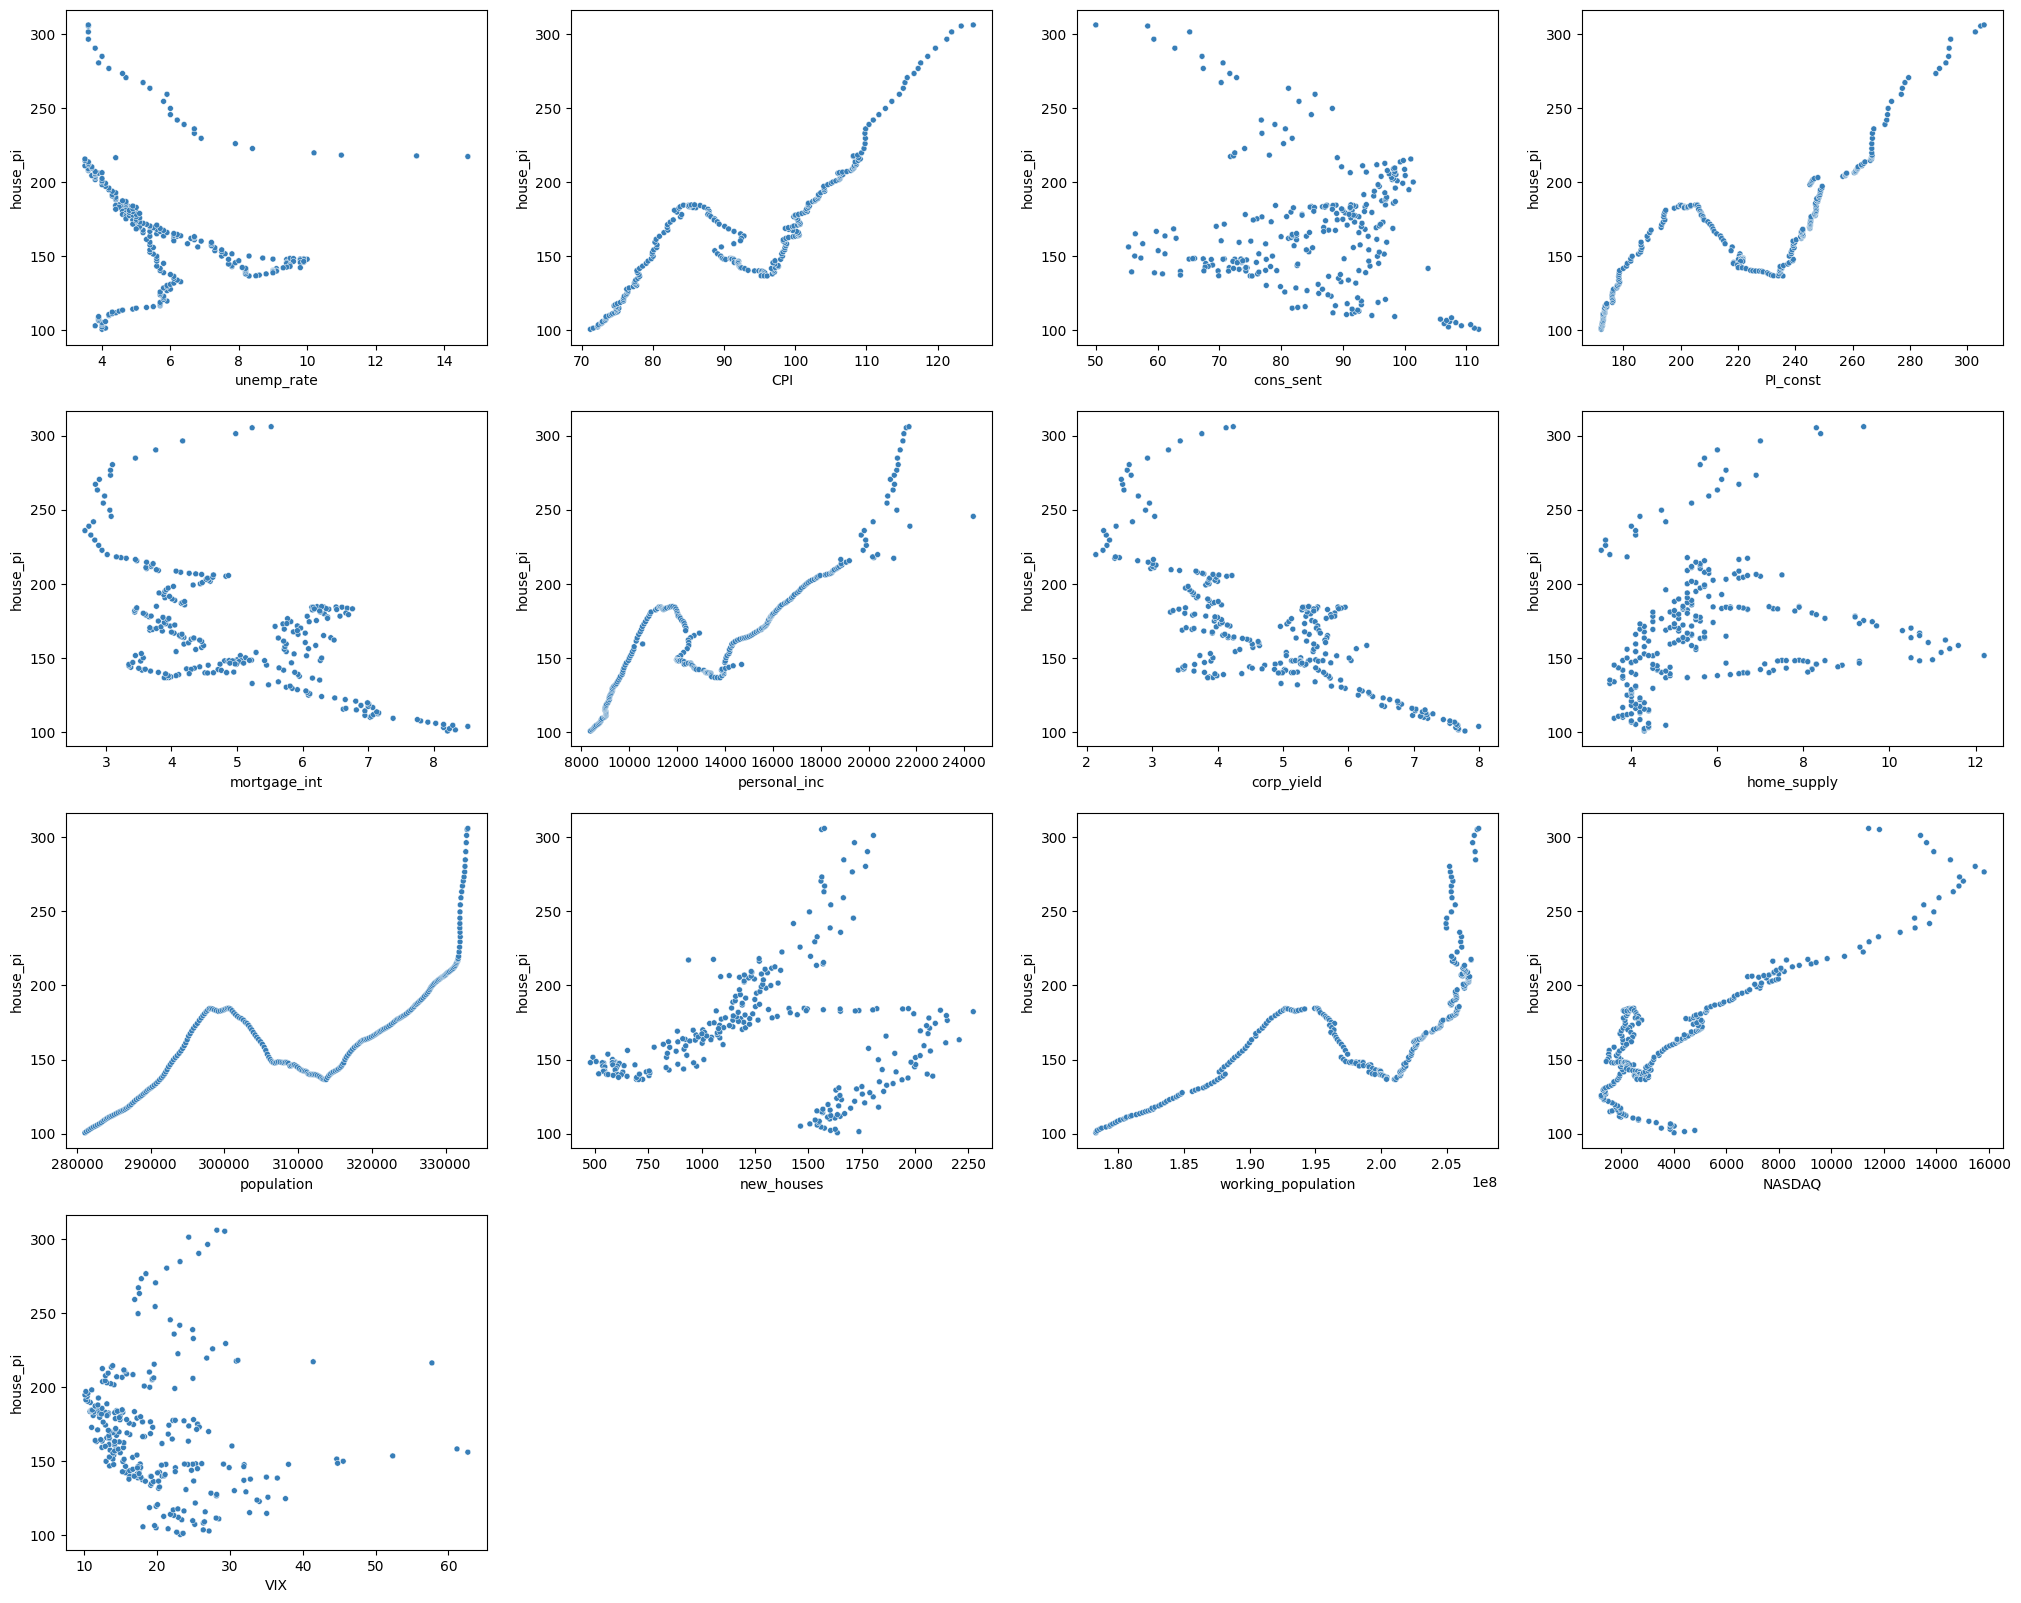

In [13]:
# plot all variables against the housing price index
cols = data.columns[2:,] # don't plot housing index against itself + see above for plot against time
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data, x = i, y = data['house_pi'], size = 5, legend = False)
    k += 1

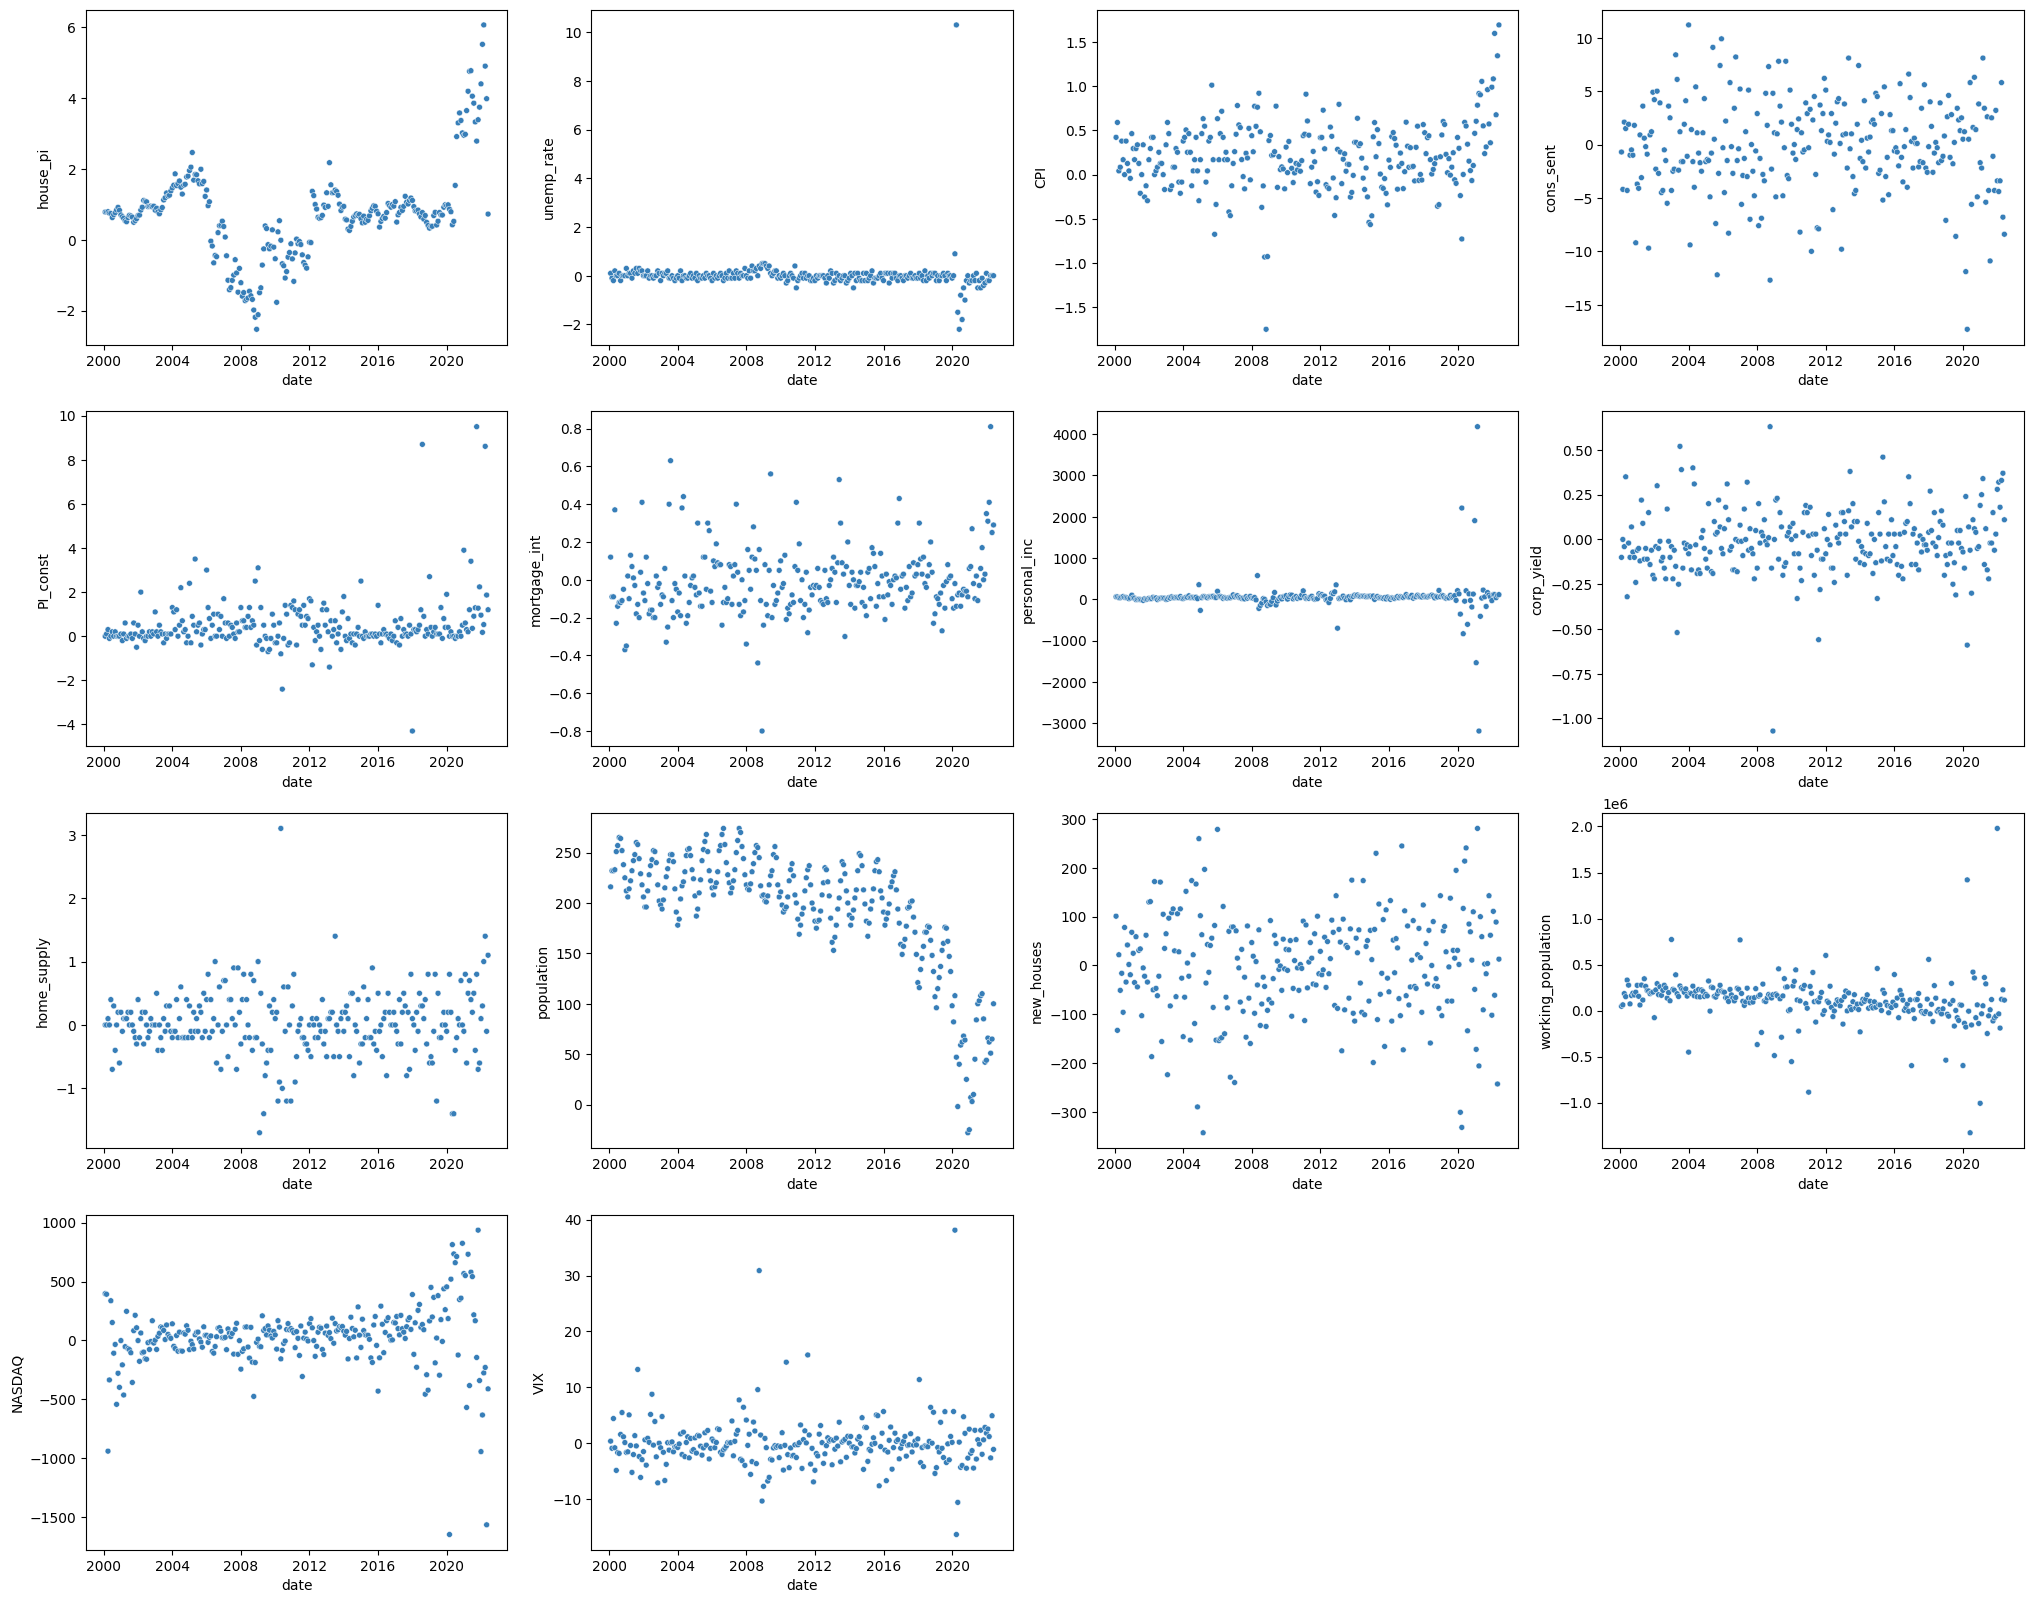

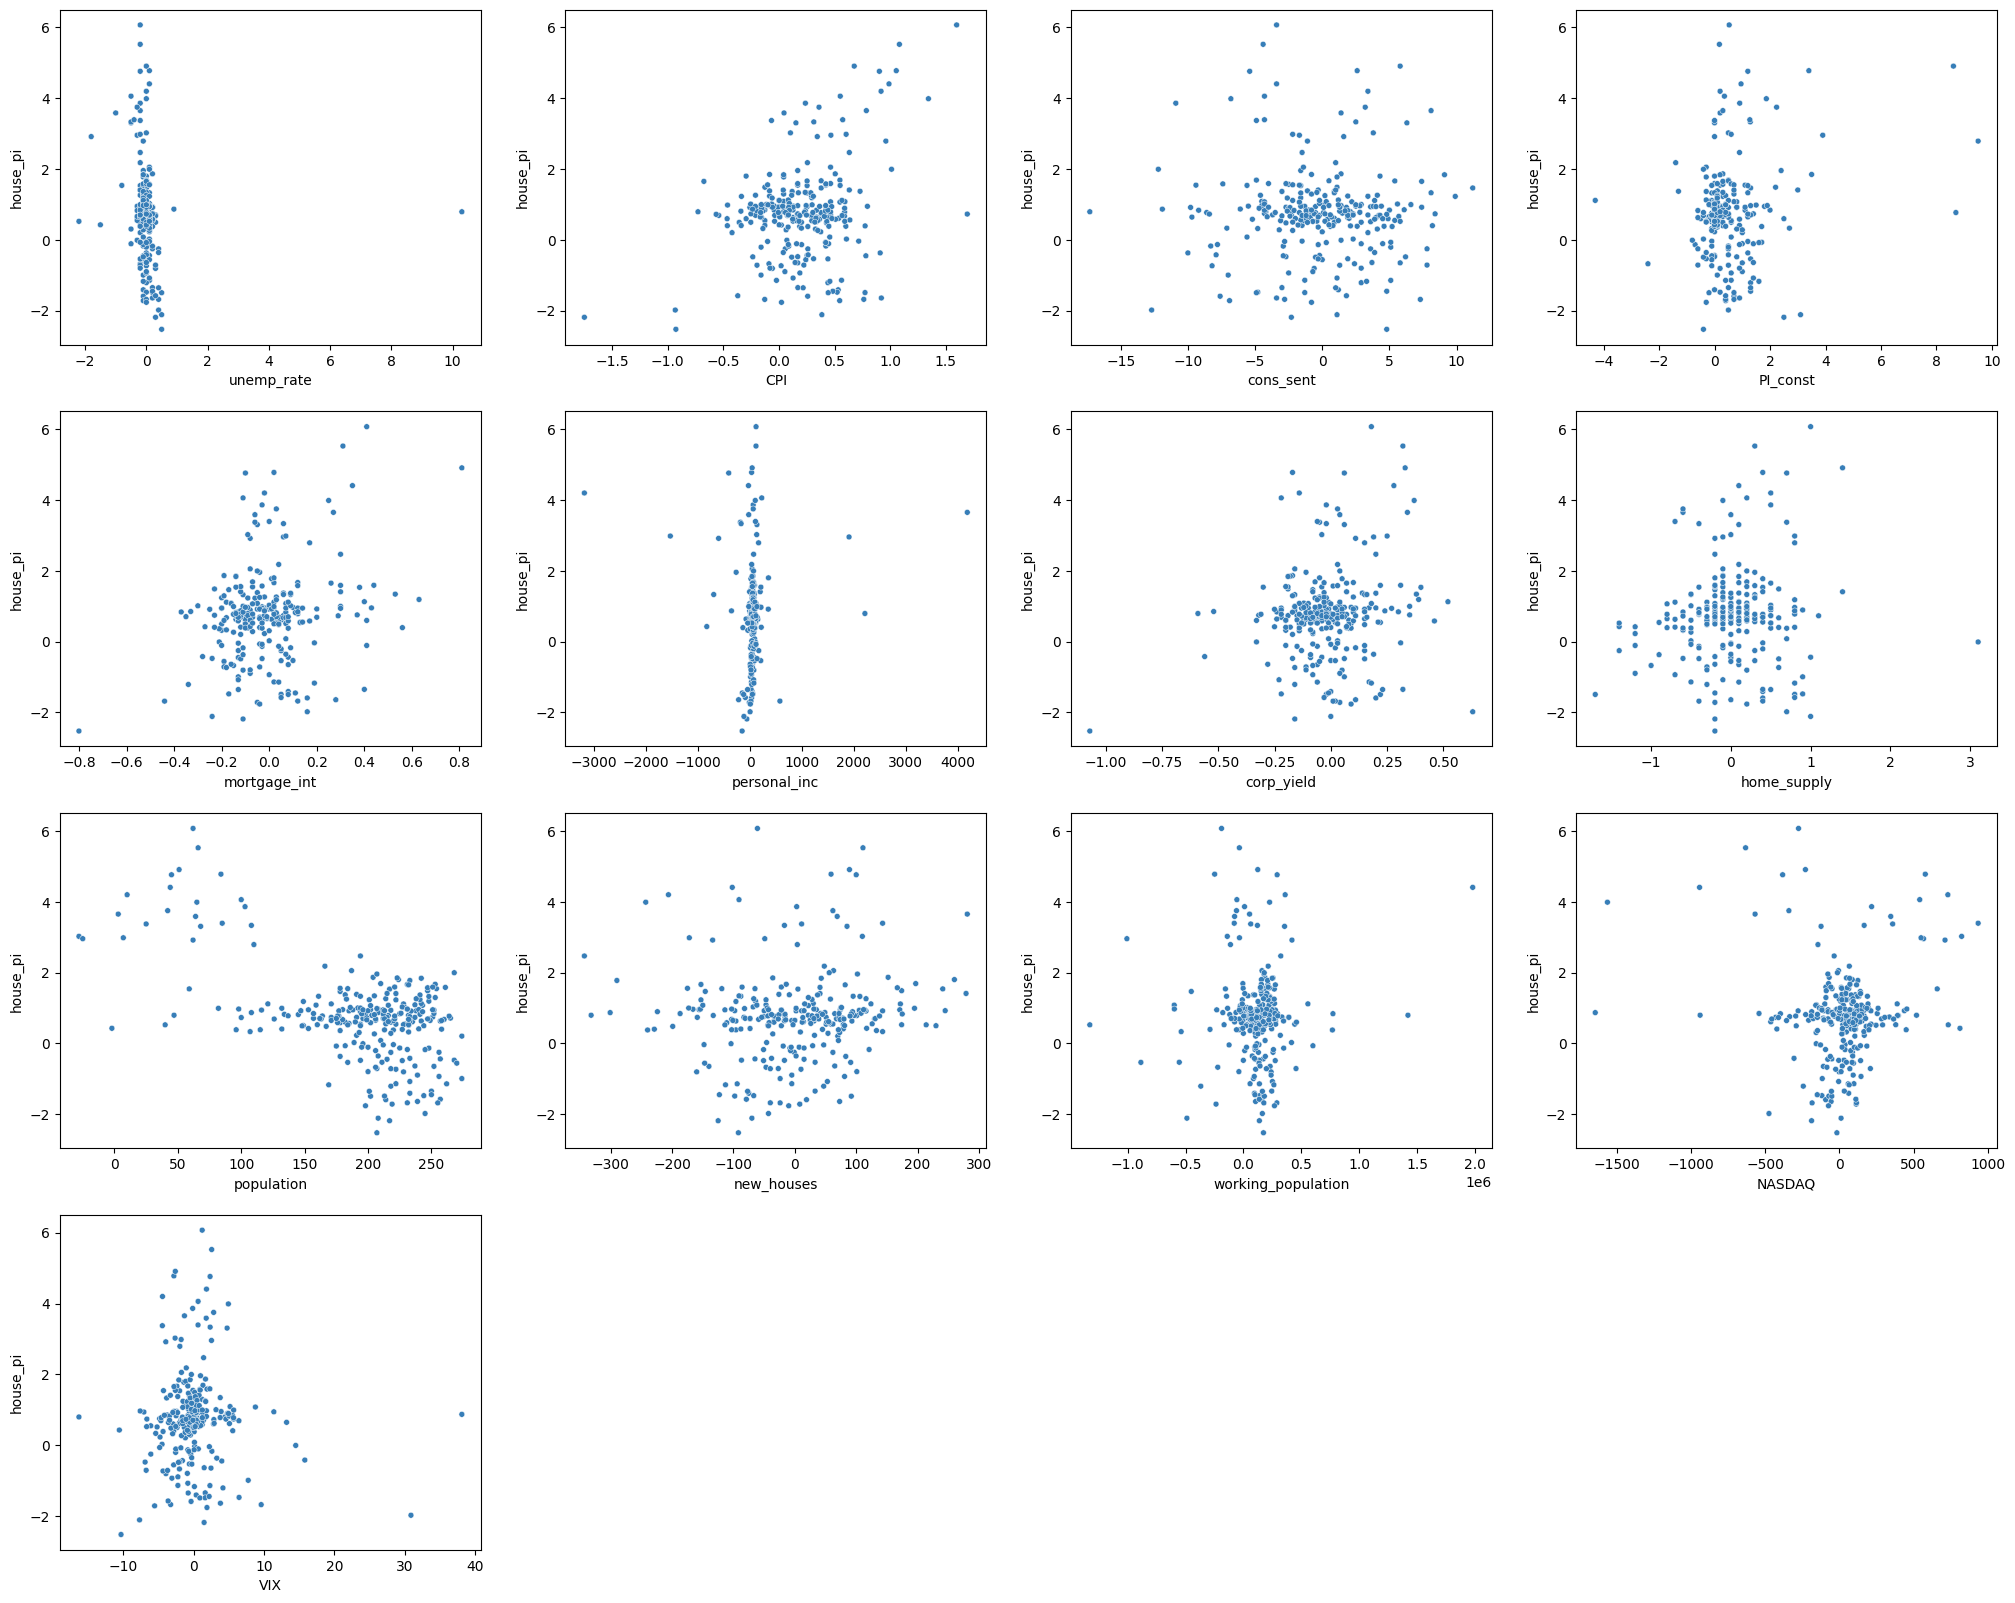

In [14]:
# for differences
## plot
if data.columns[0] == 'date':
    data_date = data.iloc[:,0]
    data_date = data_date.iloc[1:]

data_diff = data.iloc[:,1:].diff()
data_diff = data_diff.iloc[1:,:]

# plot how each variable evolves over time
cols = data_diff.columns
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data_diff, x = data_date, y = i, size = 5, legend = False)
    k += 1

# plot all variables against the housing price index
cols = data_diff.columns[1:] # don't plot housing index against itself
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data_diff, x = i, y = data_diff['house_pi'], size = 5, legend = False)
    k += 1

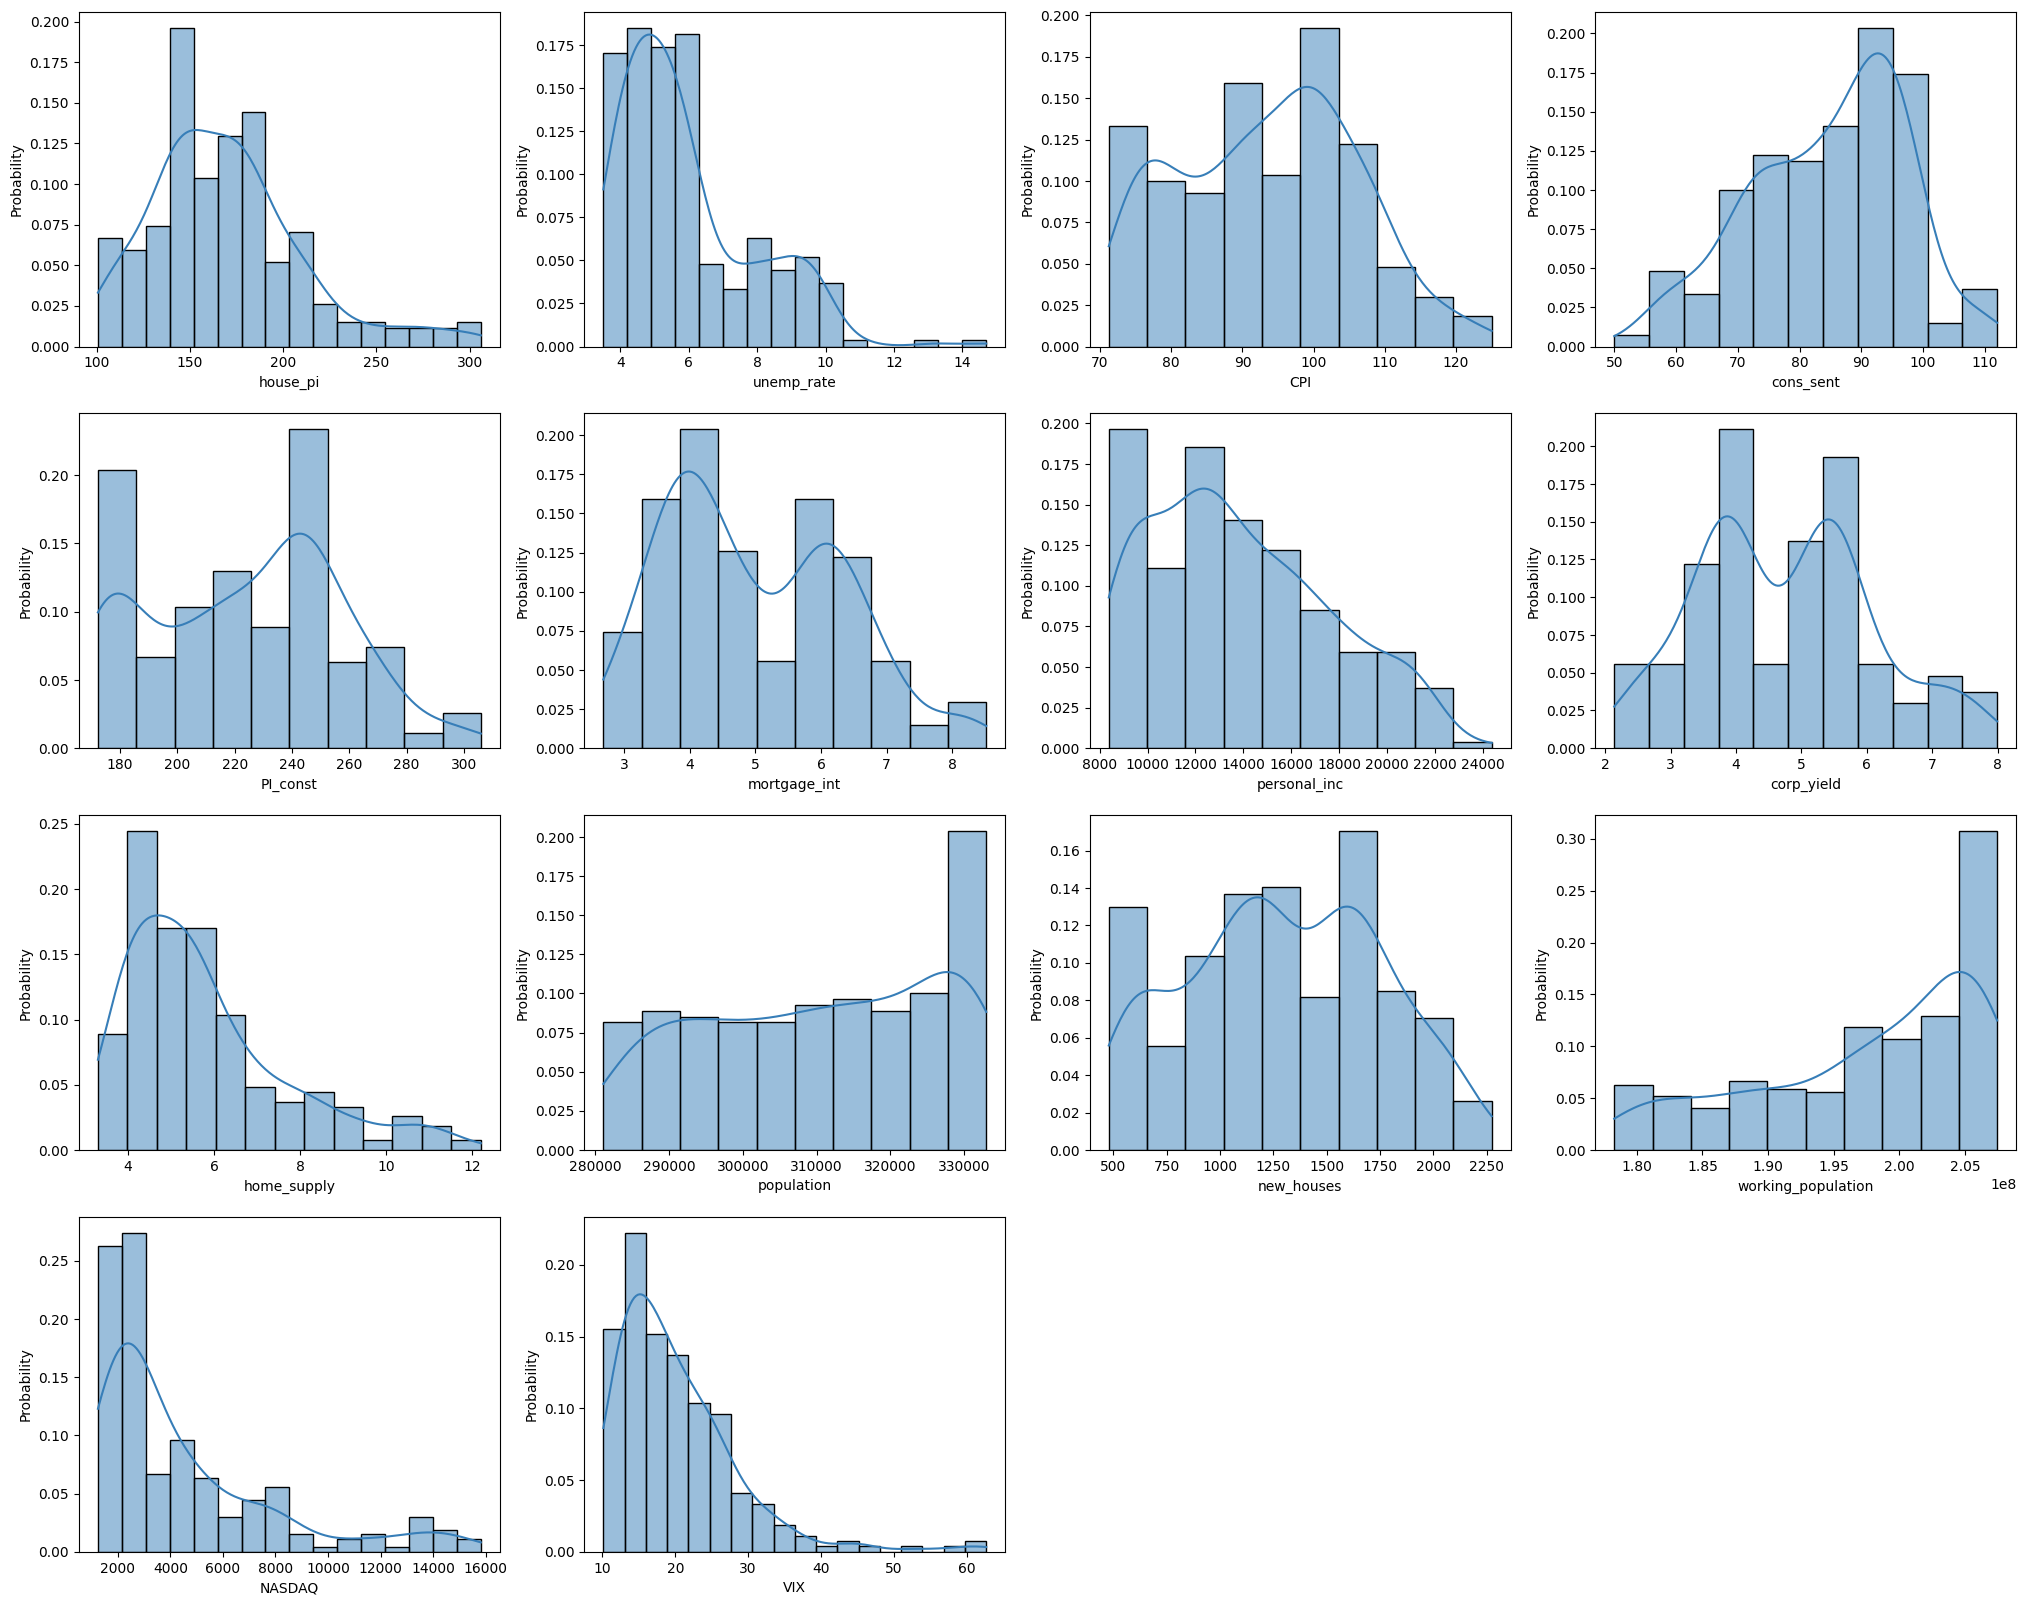

In [15]:
# distribution of the variables
cols = data.columns[1:,] #don't plot time since it's obviously uniformely distributed
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.histplot(data = data[i], stat = 'probability', kde = True)
    k += 1

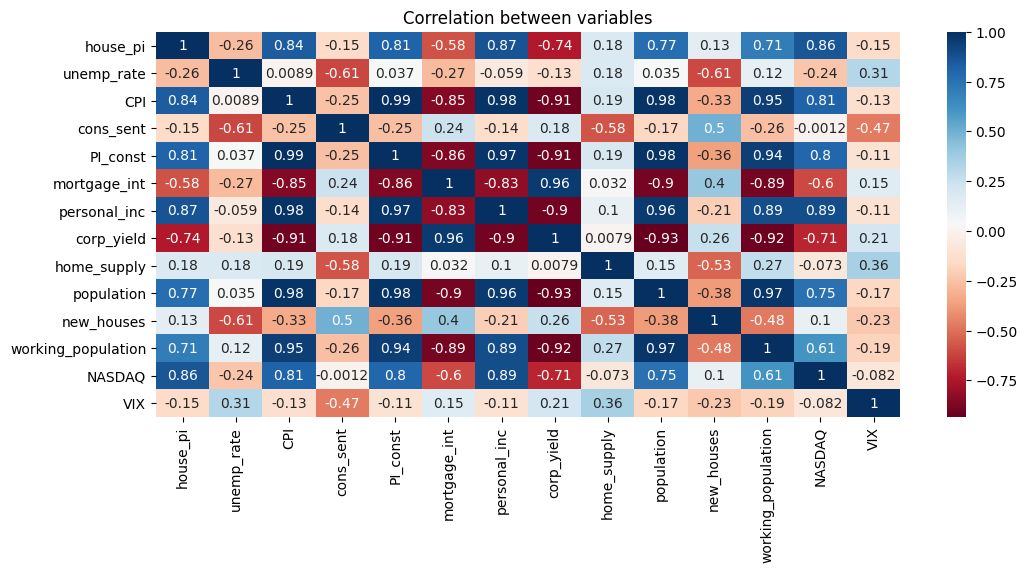

In [16]:
# correlation between the variables
plt.figure(figsize = (12, 5))
sns.heatmap(data.corr(), cmap = 'RdBu', annot = True)
plt.title('Correlation between variables')
plt.show()

If the correlation between the independent variables is high, we have an indication that we have multicollinearity which will cause problems later in the estimation and interpretation.

We see that the following independent variables have high correlation:
- unemployment rate vs. consumer sentiment: makes sense since during a recessions and/or times of crisis we have high unemployment rates as well as a diminuished consumer sentiment. Hence, also the negative correlation makes sense here.
- CPI vs. price index construction, mortagage interest rate, personal income and corporate yield:
    - CPI vs. price index construction: makes sense since if the price of goods in general increase, then it also increases for the construction sector.
    - CPI vs. mortagage interest rate and corporate yield: makes sense since one action central banks take when inflation increases, is to increase interest rates (see current world situation regarding interest rate hikes).
    - CPI vs. personal income: makes sense to some extent since if the price of goods increase, then employees ask for higher salaries to compensate for the inflation. This, however, usually happens with some delay since salaries are usually very "sticky".
- price index construction vs. mortgage interest rate, personal income and corporate yield: makes sense, see explanations for CPI vs. other variables above

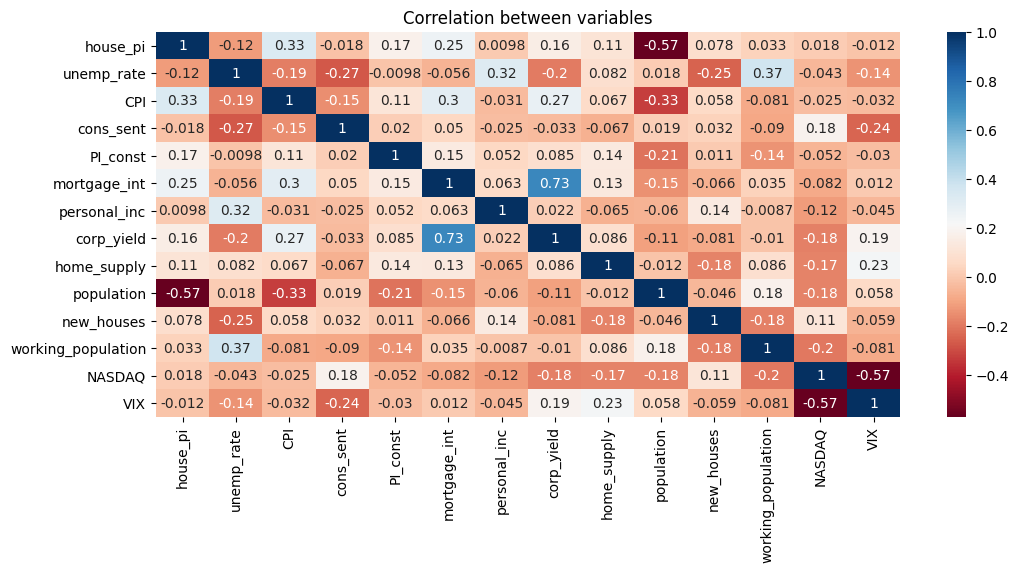

In [17]:
# for differences
# correlation between the variables
plt.figure(figsize = (12, 5))
sns.heatmap(data_diff.corr(), cmap = 'RdBu', annot = True)
plt.title('Correlation between variables')
plt.show()

## 4. Model Fitting

In [18]:
# add year and month (insert only here, i.e., after taking differences since otherwise we'd only have 1 for year or month change)
data_date_year = pd.to_datetime(data_date).dt.year
data_date_month = pd.to_datetime(data_date).dt.month

data_diff.insert(0, 'year', data_date_year)
data_diff.insert(0, 'month', data_date_month)

# initialize scaler
scaler = MinMaxScaler()

# apply scaler
data_diff_scaled = pd.DataFrame(scaler.fit_transform(data_diff), columns = data_diff.columns)

# have a look at the data
#data_diff_scaled.head()

# make train-test split
data_diff_scaled_train, data_diff_scaled_test = train_test_split(data_diff_scaled, train_size = 0.7, random_state = 100, shuffle = False)

# have a look at the data
#data_diff_scaled_train.head()

# divide data into dependent and independent variable(s)
dep_train = data_diff_scaled_train.pop('house_pi')
indep_train = data_diff_scaled_train

### 4.1 Model 1: All Predictors

In [19]:
# fit the model with all predictors WITHOUT constant
lm1_1 = sm.OLS(dep_train, indep_train).fit()

# print  summary
print(lm1_1.summary())

                                 OLS Regression Results                                
Dep. Variable:               house_pi   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              133.1
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                    1.60e-86
Time:                        14:04:33   Log-Likelihood:                          163.67
No. Observations:                 188   AIC:                                     -297.3
Df Residuals:                     173   BIC:                                     -248.8
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [20]:
# fit the model with all predictors WITH constant
indep_train1_2 = sm.add_constant(indep_train)
lm1_2 = sm.OLS(dep_train, indep_train1_2).fit()

# print  summary
print(lm1_2.summary())

                            OLS Regression Results                            
Dep. Variable:               house_pi   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     4.620
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           2.19e-07
Time:                        14:04:33   Log-Likelihood:                 167.91
No. Observations:                 188   AIC:                            -303.8
Df Residuals:                     172   BIC:                            -252.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9725      0

c:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### 4.2 Model 2: Using Only Variables Chosen by RFE

In [21]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE
lm_rfe = LinearRegression()
lm_rfe.fit(indep_train, dep_train)

rfe = RFE(lm_rfe)
rfe = rfe.fit(indep_train, dep_train)

#List of variables selected
list(zip(indep_train.columns, rfe.support_, rfe.ranking_))

#Columns where RFE support is True
indep_RFE_train = indep_train.columns[rfe.support_]
indep_RFE_train = list(indep_RFE_train)
indep_RFE_train

['year',
 'unemp_rate',
 'PI_const',
 'mortgage_int',
 'population',
 'working_population',
 'NASDAQ']

In [22]:
# fit the model using only variables chosen by RFE WITHOUT constant
indep_train2_1 = indep_train[indep_RFE_train].copy()

# fit another model taking out consumer sentiment, personal income and home supply
lm2_1 = sm.OLS(dep_train, indep_train2_1).fit()

# print  summary
print(lm2_1.summary())

                                 OLS Regression Results                                
Dep. Variable:               house_pi   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                              254.6
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                    3.95e-90
Time:                        14:04:33   Log-Likelihood:                          150.02
No. Observations:                 188   AIC:                                     -286.0
Df Residuals:                     181   BIC:                                     -263.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [23]:
# fit the model using only variables chosen by RFE but WITH constant
indep_train2_2 = indep_train[indep_RFE_train].copy()
indep_train2_2 = sm.add_constant(indep_train2_2)

# fit another model taking out consumer sentiment, personal income and home supply
lm2_2 = sm.OLS(dep_train, indep_train2_2).fit()

# print  summary
print(lm2_2.summary())

                            OLS Regression Results                            
Dep. Variable:               house_pi   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     9.496
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           5.13e-10
Time:                        14:04:33   Log-Likelihood:                 165.63
No. Observations:                 188   AIC:                            -315.3
Df Residuals:                     180   BIC:                            -289.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0226      0

c:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### 4.3 Model 3: Using Model 2 Less Insignificant Predictors

In [24]:
# fit the model using only variables chosen by RFE and dropping insignificant predictors from model 2 WITHOUT constant
indep_train3_1 = indep_train2_1[['year', 'unemp_rate', 'population', 'working_population']].copy()

# fit another model taking out consumer sentiment, personal income and home supply
lm3_1 = sm.OLS(dep_train, indep_train3_1).fit()

# print  summary
print(lm3_1.summary())

                                 OLS Regression Results                                
Dep. Variable:               house_pi   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              383.2
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                    4.85e-88
Time:                        14:04:33   Log-Likelihood:                          135.89
No. Observations:                 188   AIC:                                     -263.8
Df Residuals:                     184   BIC:                                     -250.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [25]:
# fit the model using only variables chosen by RFE and dropping insignificant predictors from model 2 WITHOUT constant
indep_train3_2 = indep_train2_1[['year', 'unemp_rate', 'population', 'working_population']].copy()
indep_train3_2 = sm.add_constant(indep_train3_2)

# fit another model taking out consumer sentiment, personal income and home supply
lm3_2 = sm.OLS(dep_train, indep_train3_2).fit()

# print  summary
print(lm3_2.summary())

                            OLS Regression Results                            
Dep. Variable:               house_pi   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     14.68
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           2.03e-10
Time:                        14:04:33   Log-Likelihood:                 162.25
No. Observations:                 188   AIC:                            -314.5
Df Residuals:                     183   BIC:                            -298.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.1134      0

c:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 5. Model Selection

In [26]:
#print('***************************************************************************************')
#print('all variables, without constant')
#print(round(lm1_1.aic, 3), '   ', round(lm1_1.bic, 2))
#print('all variables, with constant')
#print(round(lm1_2.aic, 3), '   ', round(lm1_2.bic, 2))
#print('***************************************************************************************')
#print('only variables chosen by RFE, without constant')
#print(round(lm2_1.aic, 3), '   ', round(lm2_1.bic, 2))
#print('only variables chosen by RFE, with constant')
#print(round(lm2_2.aic, 3), '   ', round(lm2_2.bic, 2))
#print('***************************************************************************************')
#print('only variables chosen by RFE but without insignificant predictors, without constant')
#print(round(lm3_1.aic, 3), '   ', round(lm3_1.bic, 2))
#print('only variables chosen by RFE but without insignificant predictors, with constant')
#print(round(lm3_2.aic, 3), '   ', round(lm3_2.bic, 2))
#print('***************************************************************************************')


In [27]:

IC =    {'model':   ['all variables, without constant',
                     'all variables, with constant',
                     'RFE variables, without constant',
                     'RFE variables, with constant',
                     'RFE variables without insignificant predictors, without constant',
                     'RFE variables without insignificant predictors, with constant'],
         'AIC':     [round(lm1_1.aic, 3),
                     round(lm1_2.aic, 3),
                     round(lm2_1.aic, 3),
                     round(lm2_2.aic, 3),
                     round(lm3_1.aic, 3),
                     round(lm3_2.aic, 3)],
         'BIC':     [round(lm1_1.bic, 3),
                     round(lm1_2.bic, 3),
                     round(lm2_1.bic, 3),
                     round(lm2_2.bic, 3),
                     round(lm3_1.bic, 3),
                     round(lm3_2.bic, 3)]}
IC_df = pd.DataFrame(data = IC)
IC_df

,model,AIC,BIC
0,"all variables, without constant",-297.334,-248.787
1,"all variables, with constant",-303.830,-252.047
2,"RFE variables, without constant",-286.046,-263.391
3,"RFE variables, with constant",-315.265,-289.374
4,RFE variables without insignificant predictors...,-263.772,-250.826
5,RFE variables without insignificant predictors...,-314.494,-298.312


Judging the values for the two information criteria, the AIC would choose Model 2 with constant and the BIC would choose Model 3 with constant.

In [28]:
# calculate VIF for the best model according to the AIC
vif = pd.DataFrame()
X = indep_train2_2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)
print("***************************")
# calculate VIF for the best model according to the BIC
vif = pd.DataFrame()
X = indep_train3_2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

             Features     VIF
0               const  575.87
1                year    1.34
5          population    1.23
6  working_population    1.08
7              NASDAQ    1.08
2          unemp_rate    1.06
4        mortgage_int    1.04
3            PI_const    1.03
***************************
             Features     VIF
0               const  367.45
1                year    1.29
3          population    1.20
4  working_population    1.08
2          unemp_rate    1.05


Judging the results from the VIF, we get satisfying results (we use as rule of thumb values below four are fine) since the value for the constant can be disregarded. We thus have no problems regarding multicollinearity.